# Your Own Analysis

Guided Mission 3의 결과를 토대로 secondary structure 선호도 조사하기
(Figure 2E 재현하기)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 실습용 bioconda 환경 설치

!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

Cloning into 'colab-biolab'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 318.16 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.condarc
./root/.bashrc.biolab
./root/.bin.priority/
./root/.bin.priority/pip3
./root/.bin.priority/pip2
./root/.bin.priority/pip
./root/.profile
./root/.vimrc
./root/.tmux.conf
--2025-06-10 01:02:02--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155472915 (148M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 1

In [ ]:
# 실습에 필요한 프로그램 설치

!conda install -y bedtools bioawk samtools

Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /root/conda

  added / updated specs:
    - bedtools
    - bioawk
    - samtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bedtools-2.31.1            |       h13024bc_3         1.5 MB  bioconda
    bioawk-1.0                 |      h577a1d6_13         198 KB  bioconda
    c-ares-1.34.5              |       hb9d3cd8_0         202 KB  conda-forge
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    conda-25.5.1               |  py313h78bf25f_0         1.1 MB  conda-forge
    expat-2.7.0                |       

In [ ]:
%cd /content/drive/MyDrive/binfo1-work/

/content/drive/MyDrive/binfo1-work


In [ ]:
# 필요한 모듈 전체 부르기
import pandas as pd
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook
import random
from PIL import Image
import pickle
import matplotlib as mpl

!pip install logomaker
import logomaker

!pip install pyfaidx
from pyfaidx import Fasta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 80.9 MB/s eta 0:00:00


## Step 1. LIN28A 결합 부위 식별

In [ ]:
# transcriptiome-wide

# 파일이 너무 커서 depth가 50 이상인것만 뽑기

#!samtools mpileup CLIP-35L33G.bam | awk '$4 >= 50' > CLIP-35L33G.pileup
#!wc -l CLIP-35L33G.pileup

In [ ]:
!tail CLIP-35L33G.pileup

MU069435.1	1559	N	346	>>>>TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT$TT$T$T$TTTTTTTTTTTTTTT$TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT	DIDHGHIIIIIIEEIEIGIIEGGBGGDG:BEBHDDFBIGIEHGIIGIIIHBGIBB>G?DI3IGBEI7GGGGI4GII=G?IIGDIIHIIEHGIHIHGEIHIG=EIHGIIHIGIIIIDIDIIIEIIIIIIGIHIIFI@GGIIIIBIIEIGHH?@IAIGI@HIBHHHFAGIGHGHDIIGIGIIBGIEFHIGGIIIIGHIHIDIIFIHIGGIH@DHGHHDIEDIIEIII8GDHHGHIBGIIHIDIAIGIHIIHEG4II>HD?IH@IFIHGIGDHH;AFGH@EGH:BCHG>IEIDIHIHIIHIIIIIIHHGHIGIIGIGFHGCII=HD@HI?IIIGHGGIHIGIDDH>HFB
MU069435.1	1560	N	341	>>>>TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT$T$T$T$TT$T$TT$T$T$T$TT$TT$TT$TTT$TT$T$T$TT$TT$T$TTT$T$TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [ ]:
def shannon_entropy(seq):
    if not seq:
        return 0
    counts = Counter(seq)
    total = sum(counts[b] for b in 'ATGC')
    if total == 0:
        return 0
    entropy = -sum((counts[b]/total) * np.log2(counts[b]/total)
                   for b in 'ATGC' if counts[b] > 0)
    return entropy
chunk_size = 1000
chunks = pd.read_csv('CLIP-35L33G.pileup', sep = '\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'], chunksize=chunk_size)
toremove = re.compile('[<>$*#^]')

# final_file = pd.DataFrame(columns = ['chrom', 'pos', '_ref', 'count', 'basereads', 'quals', 'matches', 'num_base', 'entropy'])

# for chunk in tqdm_notebook(chunks):
#   chunk['matches'] = chunk['basereads'].apply(lambda x: toremove.sub('', x))
#   chunk['num_base'] = chunk['matches'].str.len()
#   chunk['entropy'] = chunk['matches'].apply(shannon_entropy)
#   final_file = pd.concat([final_file, chunk[chunk['entropy']>=0.8]])

# final_file

In [ ]:
# final_file.to_csv('CLIP-24L33G-SHANNON-thresholded.csv')

final_file = pd.read_csv('CLIP-24L33G-SHANNON-thresholded.csv')
final_file.head()

,Unnamed: 0,chrom,pos,_ref,count,basereads,quals,matches,num_base,entropy
0,4,chr1,3222726,N,156,GGGAAAAGGAAAGGGGGAAAAGAGGGAGCAAGGAGGGGAGGAGGAG...,HB:IHGIIGGIGDFHII@IFBHGHGBHGCBI@IIHGBIGI;>E@BI...,GGGAAAAGGAAAGGGGGAAAAGAGGGAGCAAGGAGGGGAGGAGGAG...,156,1.401164
1,46,chr1,3224576,N,168,CCCG*GGGG*GGGGC*GGGGGGGGGG**GGGGGCTCTGCCCCCCCG...,BGI?H?G8HIEGHIIIBIHFIE9GIIG?=E?:HHGBA8GCB??0GH...,CCCGGGGGGGGGCGGGGGGGGGGGGGGGCTCTGCCCCCCCGCCCGG...,158,1.261116
2,318,chr1,4631665,N,170,ggggggggggggggGGGCGGCGCGGGGAGGAGAAGAAGAGGAAAAA...,GDIHIDIIIIIDEHGDHBIHGIHHBIBCH4DHII?IG?IIGI8HII...,ggggggggggggggGGGCGGCGCGGGGAGGAGAAGAAGAGGAAAAA...,170,1.071389
3,348,chr1,4631695,N,511,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HBDDDD<IHGEIIEIACBIFHBIIIHBIHHHAIDDBBHIHIIHEG:...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,501,0.834922
4,376,chr1,4631745,N,78,CCCCCCCTTTCCCTCTCTTCTCCTCTTTTcccccccCCCCCCCCCC...,8HIHHBIF7HIIFFIIIBB:GEHIBIH;IEG>GHII?IIGIBGGGG...,CCCCCCCTTTCCCTCTCTTCTCCTCTTTTcccccccCCCCCCCCCC...,78,0.834648


In [ ]:
# reference 다운받기
#!wget ftp://hgdownload.soe.ucsc.edu/goldenPath/mm39/bigZips/mm39.fa.gz

In [ ]:
!gunzip -k mm39.fa.gz

In [ ]:
final_target = final_file[final_file['chrom'].isin(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM'])]

targets = list(final_target[['chrom', 'pos']].itertuples(index=False, name=None))

In [ ]:
# AAGNHG = [
#     'AAGAAG', 'AAGACG', 'AAGATG',
#     'AAGCAG', 'AAGCCG', 'AAGCTG',
#     'AAGGAG', 'AAGGCG', 'AAGGTG',
#     'AAGTAG', 'AAGTCG', 'AAGTTG'
# ]

# AAGNGH = [
#     'AAGAGA', 'AAGAGC', 'AAGAGT',
#     'AAGCGA', 'AAGCGC', 'AAGCGT',
#     'AAGGGA', 'AAGGGC', 'AAGGGT',
#     'AAGTGA', 'AAGTGC', 'AAGTGT'
# ]

In [ ]:
# Figure에 있는쌍

AAGNGH = [
    'AAGGGT', 'AAGAGT', 'AAGAGC', 'AAGGGA', 'AAGAGA', 'AAGTGA'
]

AAGNHG = [
    'AAGGTG', 'AAGGGG', 'AAGGAG', 'AAGCAG', 'AAGTAG', 'AAGAAG', 'AAGATG'
]

In [ ]:
# AAGNHG count
# index 확인해보기

genome = Fasta("mm39.fa")

base_dict = defaultdict(lambda: [0, 0, 0, 0])

for chrom, pos in tqdm_notebook(targets):
    center = pos - 1  # GTF는 1-based이므로 보정
    start = center - 2
    end = center + 4
    hexamer = genome[chrom][start:end].seq.upper()

    if hexamer in AAGNHG:
      seq = genome[chrom][center-15:center+16].seq.upper()
      for i, base in enumerate(seq):
          rel_pos = i - 15
          if base == 'A':
              base_dict[rel_pos][0] += 1
          elif base == 'T':
              base_dict[rel_pos][1] += 1
          elif base == 'G':
              base_dict[rel_pos][2] += 1
          elif base == 'C':
              base_dict[rel_pos][3] += 1
          else:
              continue  # N or ambiguous bases 무시
      else:
        continue

<ipython-input-75-fddf51349435>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chrom, pos in tqdm_notebook(targets):


  0%|          | 0/30141 [00:00<?, ?it/s]

In [ ]:
AAGNHG_counts_df = pd.DataFrame(base_dict)
AAGNHG_counts_df = AAGNHG_counts_df.transpose()
AAGNHG_counts_df.columns = ['A', 'U', 'G', 'C']
AAGNHG_counts_df = AAGNHG_counts_df.div(AAGNHG_counts_df.sum(axis=1), axis=0)
AAGNHG_counts_df.head()

,A,U,G,C
-15,0.278472,0.222917,0.284722,0.213889
-14,0.330556,0.230556,0.252083,0.186806
-13,0.347222,0.271528,0.202083,0.179167
-12,0.272917,0.207639,0.288889,0.230556
-11,0.329861,0.202778,0.264583,0.202778


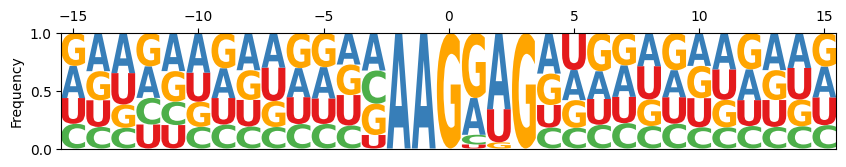

In [ ]:
color_dict = {
    'A': '#377eb8',
    'C': '#4daf4a',
    'G': 'orange',
    'U': '#e41a1c'
}

fig, ax = plt.subplots(figsize=(10, 1.5))

logo = logomaker.Logo(AAGNHG_counts_df, color_scheme=color_dict, ax=ax)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

logo.ax.set_yticks([0, 0.5, 1])
logo.ax.set_ylabel("Frequency")

plt.show()

In [ ]:
# AAGNGH count
# index 확인해보기

genome = Fasta("mm39.fa")

base_dict = defaultdict(lambda: [0, 0, 0, 0])

for chrom, pos in tqdm_notebook(targets):
    center = pos - 1  # GTF는 1-based이므로 보정
    start = center - 2
    end = center + 4
    hexamer = genome[chrom][start:end].seq.upper()

    if hexamer in AAGNGH:
      seq = genome[chrom][center-15:center+16].seq.upper()
      for i, base in enumerate(seq):
          rel_pos = i - 15
          if base == 'A':
              base_dict[rel_pos][0] += 1
          elif base == 'T':
              base_dict[rel_pos][1] += 1
          elif base == 'G':
              base_dict[rel_pos][2] += 1
          elif base == 'C':
              base_dict[rel_pos][3] += 1
          else:
              continue  # N or ambiguous bases 무시
      else:
        continue

<ipython-input-78-48acf47416df>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chrom, pos in tqdm_notebook(targets):


  0%|          | 0/30141 [00:00<?, ?it/s]

In [ ]:
AAGNGH_counts_df = pd.DataFrame(base_dict)
AAGNGH_counts_df = AAGNGH_counts_df.transpose()
AAGNGH_counts_df.columns = ['A', 'U', 'G', 'C']
AAGNGH_counts_df = AAGNGH_counts_df.div(AAGNGH_counts_df.sum(axis=1), axis=0)
AAGNGH_counts_df.head()

,A,U,G,C
-15,0.300513,0.263590,0.250256,0.185641
-14,0.310769,0.277949,0.236923,0.174359
-13,0.270769,0.264615,0.278974,0.185641
-12,0.282051,0.248205,0.244103,0.225641
-11,0.311795,0.275897,0.236923,0.175385


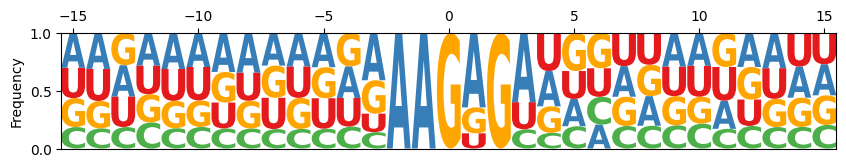

In [ ]:
color_dict = {
    'A': '#377eb8',
    'C': '#4daf4a',
    'G': 'orange',
    'U': '#e41a1c'
}

fig, ax = plt.subplots(figsize=(10, 1.5))

logo = logomaker.Logo(AAGNGH_counts_df, color_scheme=color_dict, ax=ax)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

logo.ax.set_yticks([0, 0.5, 1])
logo.ax.set_ylabel("Frequency")

plt.show()

In [ ]:
# 일단 position별로 저장해둬야 freq 계산가능할것같음

genome = Fasta("mm39.fa")

pos_dictionary = {}

for j in range(31):
    pos_dictionary[j - 15] = ''

# 전체 sequence에 대해서 계산
for chrom, pos in tqdm_notebook(targets):
    center = pos - 1  # GTF 보정 (1-based → 0-based)
    seq = genome[chrom][center-15:center+16].seq.upper()
    if len(seq) != 31:
       continue  # 길이 부족한 경우 skip

    for i in range(31):
       pos_dictionary[i - 15] = pos_dictionary[i - 15] + seq[j]

<ipython-input-21-ad3572340743>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chrom, pos in tqdm_notebook(targets):


  0%|          | 0/30141 [00:00<?, ?it/s]

In [ ]:
# Watson-Crick pair 정의
def is_wc_pair(base1, base2):
    return (base1, base2) in [('A', 'T'), ('T', 'A'), ('G', 'C'), ('C', 'G')]

# position 쌍에 대해 wc pair 빈도 저장용
pair_freqs = defaultdict(list)  # {(i,j): [0.2, 0.25, ..., 0.18]} 형태

positions = sorted(pos_dictionary.keys())  # [-15, ..., +15]

# 1000번 permutation
# for _ in tqdm_notebook(range(1000)):
#     # 위치별로 염기들을 랜덤 셔플해서 새로운 permuted dict 생성
#     permuted_dict = {
#         pos: random.sample(pos_dictionary[pos], len(pos_dictionary[pos]))
#         for pos in positions
#     }

#     # 각 위치쌍에 대해 WC pair 빈도 계산
#     for i in positions:
#         for j in positions:
#             if i >= j:
#                 continue  # 중복 제거

#             base_list_i = permuted_dict[i]
#             base_list_j = permuted_dict[j]

#             total = len(base_list_i)
#             wc_count = sum(
#                 is_wc_pair(b1, b2)
#                 for b1, b2 in zip(base_list_i, base_list_j)
#             )
#             freq = wc_count / total
#             pair_freqs[(i, j)].append(freq)

# # 최종 기대값 계산
# expected_freqs = {
#     (i, j): sum(freqs) / len(freqs)
#     for (i, j), freqs in pair_freqs.items()
# }

<ipython-input-22-0925c156dd08>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# 한번 돌리는데 너무 오래걸려서 그냥 저장
# with open('expected_freqs.pkl', 'wb') as f:
#     pickle.dump(expected_freqs, f)

# 불러오기
with open('expected_freqs.pkl', 'rb') as f:
    expected_freqs = pickle.load(f)

# expected_freqs

In [ ]:
# original WC pair freq 계산하기: AAGNGH

genome = Fasta("mm39.fa")

# 위치별 염기 빈도 저장 (A, T, G, C)
base_dict = defaultdict(lambda: [0, 0, 0, 0])

wc_pair_count = defaultdict(int)
wc_pairs = {'AT', 'TA', 'GC', 'CG'}

valid_seq_count = 0

for chrom, pos in tqdm_notebook(targets):
    center = pos - 1  # GTF 보정 (1-based → 0-based)
    start = center - 2
    end = center + 4
    hexamer = genome[chrom][start:end].seq.upper()

    if hexamer in AAGNGH:
      seq = genome[chrom][center-15:center+16].seq.upper()
      if len(seq) != 31:
          continue  # 길이 부족한 경우 skip
      valid_seq_count += 1

      for i in range(31):
          base_i = seq[i]
          for j in range(31):
              base_j = seq[j]
              pair = base_i + base_j
              if pair in wc_pairs:
                  rel_i = i - 15
                  rel_j = j - 15
                  wc_pair_count[(rel_i, rel_j)] += 1

<ipython-input-116-e07c9966de08>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chrom, pos in tqdm_notebook(targets):


  0%|          | 0/30141 [00:00<?, ?it/s]

In [ ]:
positions = list(range(-15, 16))
pos_to_idx = {pos: idx for idx, pos in enumerate(positions)}

rel_freq_matrix = np.full((31, 31), np.nan)

# hexamer motif 위치 범위 (-2 ~ +3)
hexamer_range = set(range(-2, 4))

for i in positions:
    for j in positions:
        if i < j:
            # hexamer 영역에 둘 다 포함되면 skip
            if i in hexamer_range and j in hexamer_range:
                continue

            # 관측 상대 빈도
            observed = wc_pair_count[(i, j)] / valid_seq_count

            # 기대 상대 빈도 (permutation 평균)
            expected = expected_freqs[(i, j)]

            if expected > 0:
                rel_freq_matrix[pos_to_idx[j], pos_to_idx[i]] = observed / expected

In [ ]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # vmin < midpoint < vmax 조건
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        # normalize 아래쪽 (vmin~midpoint)
        result, is_scalar = self.process_value(value)
        resdat = result.data

        # 아래쪽 구간
        mask = resdat <= midpoint
        resdat[mask] = 0.5 * (resdat[mask] - vmin) / (midpoint - vmin)
        # 위쪽 구간
        mask = resdat > midpoint
        resdat[mask] = 0.5 + 0.5 * (resdat[mask] - midpoint) / (vmax - midpoint)

        if is_scalar:
            resdat = resdat[0]
        return result

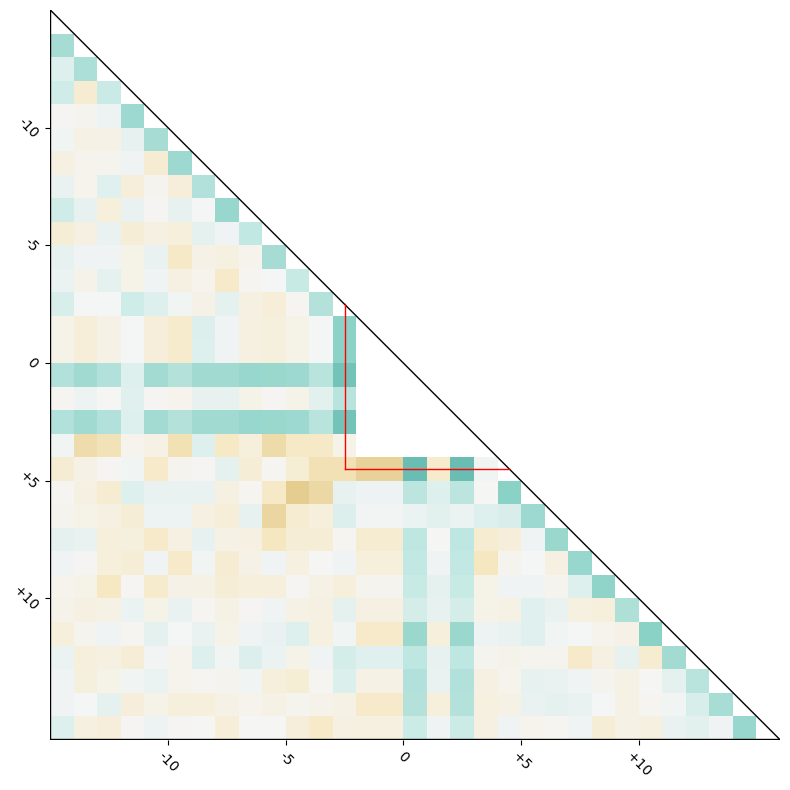

In [ ]:
# AAGNGH

fig, ax = plt.subplots(figsize=(8, 8))

norm = MidpointNormalize(vmin=0.5, vmax=2.0, midpoint=1)

heatmap = sns.heatmap(rel_freq_matrix, xticklabels=positions, yticklabels=positions,
                      cmap="BrBG_r",
                      center=1.0,
                      vmin=0.5, vmax=2.0,
                      ax=ax,
                      cbar=False)

# seaborn heatmap 내부의 이미지 객체에 직접 norm 적용
# heatmap.collections[0].set_norm(norm)

ax.plot([0, 31], [0, 31], color='black', linewidth=1)
ax.plot([0, 0], [0, 31], color='black', linewidth=1)
ax.plot([30.95, 0], [30.95, 30.95], color='black', linewidth=1)

for spine in ax.spines.values():
    spine.set_visible(False)

ticks_to_show = [-10, -5, 0, 5, 10]

tick_labels = [f'+{t}' if t > 0 else str(t) for t in ticks_to_show]

ax.set_xticks([pos_to_idx[t] for t in ticks_to_show])
ax.set_xticklabels(tick_labels, rotation=-45)

ax.set_yticks([pos_to_idx[t] for t in ticks_to_show])
ax.set_yticklabels(tick_labels, rotation=-45)

ax.plot([12.5, 19.5], [19.5, 19.5], color='red', linewidth=1)
ax.plot([12.5, 12.5], [12.5, 19.5], color='red', linewidth=1)

# plt.title("Raw WC Pair Frequency Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# original WC pair freq 계산하기: AAGNHG

genome = Fasta("mm39.fa")

# 위치별 염기 빈도 저장 (A, T, G, C)
base_dict = defaultdict(lambda: [0, 0, 0, 0])

wc_pair_count = defaultdict(int)
wc_pairs = {'AT', 'TA', 'GC', 'CG'}

valid_seq_count = 0

for chrom, pos in tqdm_notebook(targets):
    center = pos - 1  # GTF 보정 (1-based → 0-based)
    start = center - 2
    end = center + 4
    hexamer = genome[chrom][start:end].seq.upper()

    if hexamer in AAGNHG:
      seq = genome[chrom][center-15:center+16].seq.upper()
      if len(seq) != 31:
          continue  # 길이 부족한 경우 skip
      valid_seq_count += 1

      for i in range(31):
          base_i = seq[i]
          for j in range(31):
              base_j = seq[j]
              pair = base_i + base_j
              if pair in wc_pairs:
                  rel_i = i - 15
                  rel_j = j - 15
                  wc_pair_count[(rel_i, rel_j)] += 1

<ipython-input-124-2d88902be1bf>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chrom, pos in tqdm_notebook(targets):


  0%|          | 0/30141 [00:00<?, ?it/s]

In [ ]:
positions = list(range(-15, 16))
pos_to_idx = {pos: idx for idx, pos in enumerate(positions)}

# 초기화된 relative frequency matrix
rel_freq_matrix = np.full((31, 31), np.nan)

# hexamer motif 위치 범위 (-2 ~ +3) 제외
hexamer_range = set(range(-2, 4))

for i in positions:
    for j in positions:
        if i < j:
            # hexamer 영역에 둘 다 포함되면 skip
            if i in hexamer_range and j in hexamer_range:
                continue

            # 관측 상대 빈도
            observed = wc_pair_count[(i, j)] / valid_seq_count

            # 기대 상대 빈도 (permutation 평균)
            expected = expected_freqs[(i, j)]

            if expected > 0:
                rel_freq_matrix[pos_to_idx[j], pos_to_idx[i]] = observed / expected

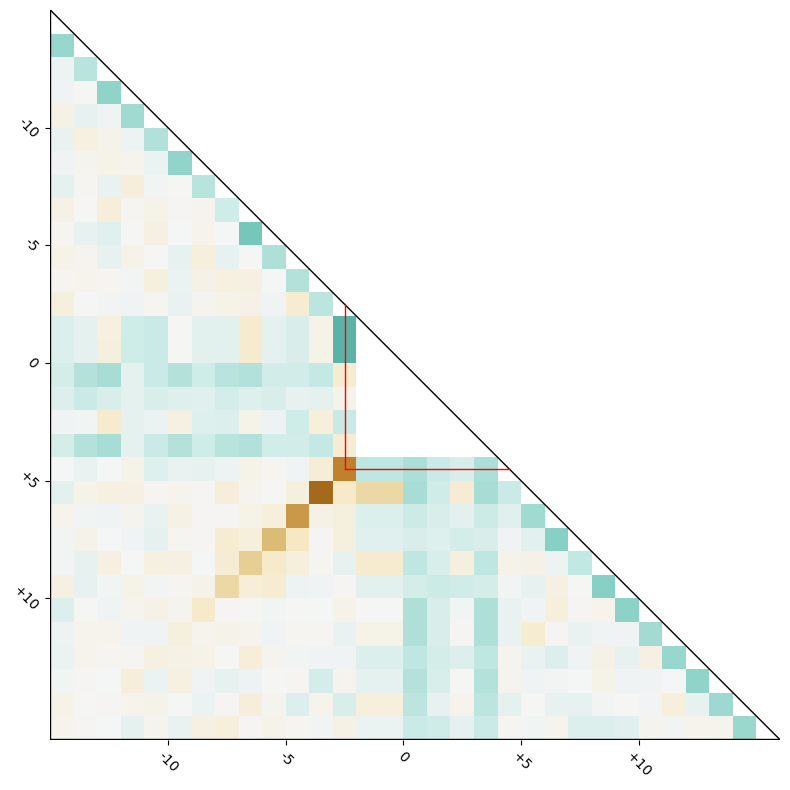

In [ ]:
norm = MidpointNormalize(vmin=0.5, vmax=2.0, midpoint=1)

fig, ax = plt.subplots(figsize=(8, 8))

heatmap = sns.heatmap(rel_freq_matrix, xticklabels=positions, yticklabels=positions,
                      cmap="BrBG_r",
                      center=1.0,
                      vmin=0.5, vmax=2.0,
                      ax=ax,
                      cbar=False)

# seaborn heatmap 내부의 이미지 객체에 직접 norm 적용
# heatmap.collections[0].set_norm(norm)

ax.plot([0, 31], [0, 31], color='black', linewidth=1)
ax.plot([0, 0], [0, 31], color='black', linewidth=1)
ax.plot([30.95, 0], [30.95, 30.95], color='black', linewidth=1)

for spine in ax.spines.values():
    spine.set_visible(False)

ticks_to_show = [-10, -5, 0, 5, 10]
tick_labels = [f'+{t}' if t > 0 else str(t) for t in ticks_to_show]

ax.set_xticks([pos_to_idx[t] for t in ticks_to_show])
ax.set_xticklabels(tick_labels, rotation=-45)

ax.set_yticks([pos_to_idx[t] for t in ticks_to_show])
ax.set_yticklabels(tick_labels, rotation=-45)

ax.plot([12.5, 19.5], [19.5, 19.5], color='red', linewidth=1)
ax.plot([12.5, 12.5], [12.5, 19.5], color='red', linewidth=1)

plt.tight_layout()
plt.show()

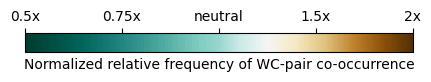

In [ ]:
cmap = plt.get_cmap("BrBG_r")
norm = MidpointNormalize(vmin=0.5, vmax=2.0, midpoint=1)

fig, ax = plt.subplots(figsize=(5, 0.5))
fig.subplots_adjust(bottom=0.5)

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal')

ticks = [0.5, 0.75, 1, 1.5, 2]
cb.set_ticks(ticks)
cb.set_ticklabels(['0.5x', '0.75x', 'neutral', '1.5x', '2x'])

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

cb.set_label('Normalized relative frequency of WC-pair co-occurrence')
cb.ax.xaxis.set_label_position('bottom')

plt.show()